# <center> 1. Extracting and Visualizing Walmart Data</h1>

### Get data from:

* [Walmart revenue (web page)](https://www.macrotrends.net/stocks/charts/WMT/walmart/revenue)
* Walmart Stock Data (yfinance library)

We will retrieve the latest financial data from the web.

Then we will split it to test and training sets. 

Then we train our model on training set. 

Made a forecast.

And check it by comparing forecast with test data that were not involved in training the model.



In [1]:
!pip install pmdarima
!pip install yfinance
!pip install requests
!pip install bs4

     |████████████████████████████████| 1.5 MB 421 kB/s 
     |████████████████████████████████| 2.1 MB 3.4 MB/s 
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=508746781af7551907021084b1a02bd662704d34f08913aeccf9b1a0ffc60e85
  Stored in directory: /root/.cache/pip/wheels/aa/8a/36/59ed4f6fbcb6100967618eeb0696046bf9777a41ac2ff1f9b9
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=279492c23e9b5f2efbaac013515bdd120d46ede4bf2d9b5cf50abd0aafa1d4dc
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking
     |████████████████████████████████| 115 kB 410 kB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=cf2c1736c0d0dbefcf

In [2]:
import pandas as pd
import numpy as np

import yfinance as yf
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

import statsmodels.api as sm
from fbprophet import Prophet
import xgboost as xgb

from sklearn.metrics import mean_absolute_error

import pmdarima 
from pmdarima import auto_arima

from statsmodels.tsa.arima_model import ARIMA
from statsmodels import tsa


In [3]:
# Use yfinance to Extract Walmart Stock Data
walmart = yf.Ticker("WMT")
walmart_data = walmart.history(period="16y")
walmart_data = walmart_data.reset_index()
walmart_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2005-03-07,37.437315,37.620625,37.077749,37.211704,10268600,0.0,0
1,2005-03-08,37.084804,37.190560,36.838043,36.957897,9411100,0.0,0
2,2005-03-09,36.943787,37.077743,36.859181,36.979038,10108200,0.0,0
3,2005-03-10,36.979050,37.056604,36.711136,36.767540,8096500,0.0,0
4,2005-03-11,36.823948,36.831000,36.288123,36.379776,9248600,0.0,0


In [4]:
# Use Webscraping to Extract Walmart Revenue Data
# Using beautiful soup extract the table with Walmart Quarterly Revenue and store it into a dataframe

url = 'https://www.macrotrends.net/stocks/charts/WMT/walmart/revenue'
html_data = requests.get(url)
soup = BeautifulSoup(html_data.text, "html.parser")

head1 = soup.findAll("div", class_="col-xs-6")[1].find("th").contents[0] # Get 2nd <div>, then 1st part of <th>
head2 = soup.findAll("div", class_="col-xs-6")[1].find("th").find("span").contents[0] # Get 2nd <div>, then 1st part of <span>

table1 = soup.findAll("div", class_="col-xs-6")[1].find("tbody")

In [5]:
walmart_revenue = pd.DataFrame(columns=["Date", "Price"])
for row in table1.find_all("tr"):
    row = row.find_all("td")
    Date = row[0].contents[0]
    Price = row[1].contents[0].replace("$","").replace(",","")    
    walmart_revenue = walmart_revenue.append({"Date":Date, "Price":Price}, ignore_index=True)

walmart_revenue.reset_index(inplace = True)
del walmart_revenue['index']

# Drop NaN
walmart_revenue = walmart_revenue.dropna()

# Convert date type(object) to DATE type(datetime64):
for i in range(len(walmart_revenue['Date'])):
        walmart_revenue['Date'].iloc[i] = walmart_revenue['Date'][i][0:4] + '-' + walmart_revenue['Date'][i][5:7] + "-" + walmart_revenue['Date'][i][8:10] + " 00:00:00"

walmart_revenue.Price = walmart_revenue.Price.astype('float')
walmart_revenue.Date = walmart_revenue.Date.astype('datetime64')

Text(0.5, 1.0, 'Walmart Stock Data')

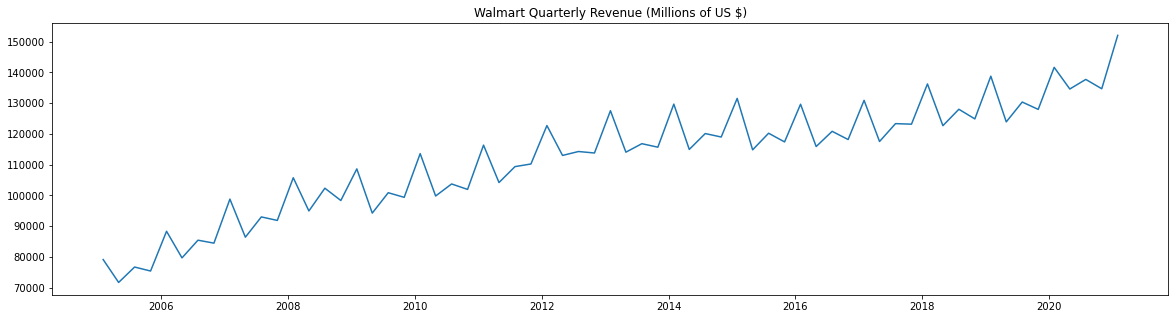

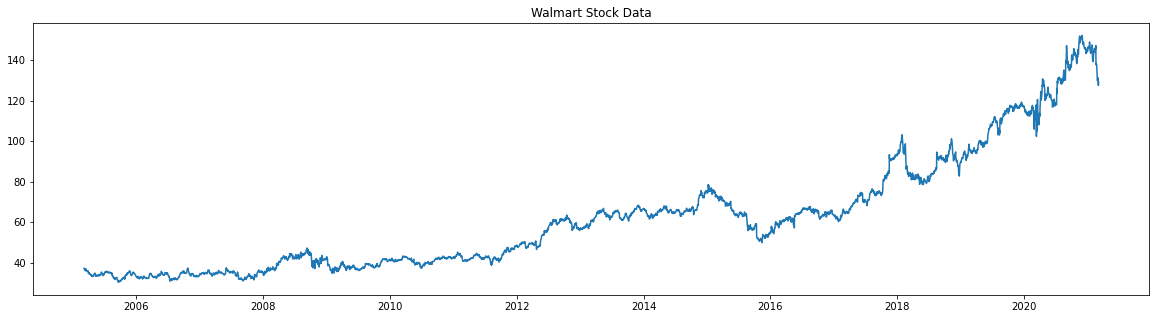

In [6]:
plt.figure(figsize=(20,5))
plt.plot(walmart_revenue.Date, walmart_revenue.Price)
plt.title(head1 +' '+ head2) # Info from web page

plt.figure(figsize=(20,5))
plt.plot(walmart_data.Date, walmart_data.Close)
plt.title('Walmart Stock Data')

# <center> 2. Time Series:

In [7]:
################################################
# Walmart Walmart Quarterly Revenue Data Split #
################################################

walmart_revenue_array = walmart_revenue.Price.copy() # from DataFrame to array

test = walmart_revenue.iloc[:20,:]
train = walmart_revenue.iloc[20:,:]
# print('TRAIN: ',train.shape, train.head())
# print('TEST: ',test.shape, test.head())

train = train.set_index('Date')
train = train.Price.copy() # from DataFrame to array

test = test.set_index('Date')
test = test.Price.copy() # from DataFrame to array

ARIMA is a model which is used for predicting future trends on a time series data. It is model that form of regression analysis. 
* **AR (Autoregression) :** Model that shows a changing variable that regresses on its own lagged/prior values.
* **I (Integrated) :**  Differencing of raw observations to allow for the time series to become stationary
* **MA (Moving average) :** Dependency between an observation and a residual error from a moving average model
    
**Prophet** is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
    
**XGBoost** can also be used for time series forecasting, although it requires that the time series dataset be transformed into a supervised learning problem first. It also requires the use of a specialized technique for evaluating the model called walk-forward validation, as evaluating the model using k-fold cross validation would result in optimistically biased results.

**LSTM** stands for long short term memory. It is a model or architecture that extends the memory of recurrent neural networks. Typically, recurrent neural networks have ‘short term memory’ in that they use persistent previous information to be used in the current neural network. Essentially, the previous information is used in the present task. That means we do not have a list of all of the previous information available for the neural node. LSTM introduces long-term memory into recurrent neural networks. It mitigates the vanishing gradient problem, which is where the neural network stops learning because the updates to the various weights within a given neural network become smaller and smaller.

## <center> ARIMA:

In [8]:
# Tune ARIMA
auto_arima(train, start_p=0, start_q=0, max_p=4, max_q=4, m=4, d=None, seasonal=True, 
           start_P=0, D=0, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=922.668, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=934.485, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=906.808, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=915.249, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=933.140, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=931.846, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=897.801, Time=0.20 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=892.827, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=894.095, Time=0.15 sec
 ARIMA(1,1,0)(2,0,2)[4] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,1,0)(1,0,2)[4] intercept   : AIC=894.422, Time=0.21 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=906.751, Time=0.15 sec
 ARIMA(2,1,0)(2,0,1)[4] intercept   : AIC=893.716, Time=0.32 sec
 ARIMA(1,1,1)(2,0,1)[4] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,1)(2,0,1)[4] intercept   : AIC=902.391, Time

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 4),
      suppress_warnings=True, with_intercept=False)

In [9]:
# ARIMA
model_AS = sm.tsa.statespace.SARIMAX(train,order=(0,1,0),seasonal_order=(1,0,1,4))
results_AS = model_AS.fit()
print('AIC =', results_AS.aic)
forecast_AS = results_AS.forecast(steps=test.shape[0])

model_A = ARIMA(train, order=(1, 0, 1))
results_A = model_A.fit()
print('AIC =', results_A.aic)
forecast_A = results_A.forecast(steps=test.shape[0])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency -1Q-OCT will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency -1Q-OCT will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


AIC = 877.8895539508298
AIC = 943.7249872100377


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  w

## <center> Prophet:

In [10]:
# Prophet

model_P = Prophet(interval_width=0.55)
model_P.fit(pd.DataFrame({'ds': train.index, 'y':train}))
future_dates = model_P.make_future_dataframe(periods=test.shape[0], freq='3m')
results_P = model_P.predict(future_dates[train.shape[0]:])
forecast_P = results_P.set_index('ds').yhat
#model_P.make_seasonality_features(period=24*7)


## <center> XGBoost:

In [11]:
# XGBoost

def to_X(data):
    return pd.Series(data.index).apply(lambda x: (x - data.index[0]).components.days).values.reshape(-1,1)

model_X = xgb.XGBRegressor(learning_rate=0.001,n_estimators=5000,
                                     max_depth=12, min_child_weight=0,
                                     gamma=0, subsample=0.5,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=300,
                                     reg_alpha=0.00006)

model_X.fit(to_X(train), train.values,
        eval_set=[(to_X(train), train.values), (to_X(test), test.values)],
        early_stopping_rounds=500, #stop if 500 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

forecast_X = model_X.predict(to_X(test))

[12:04:07] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


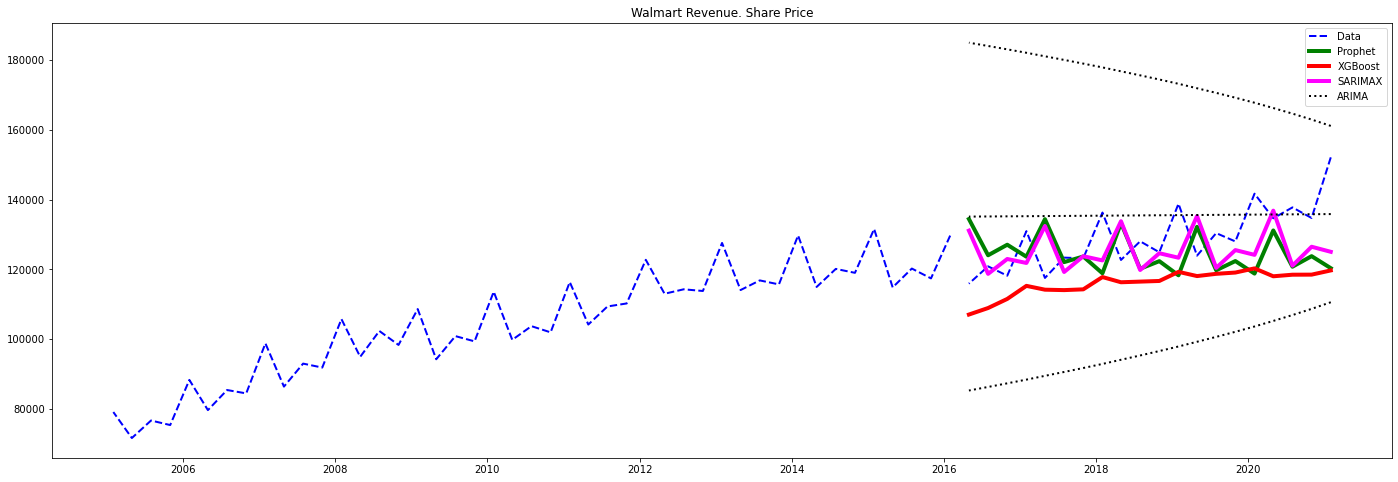

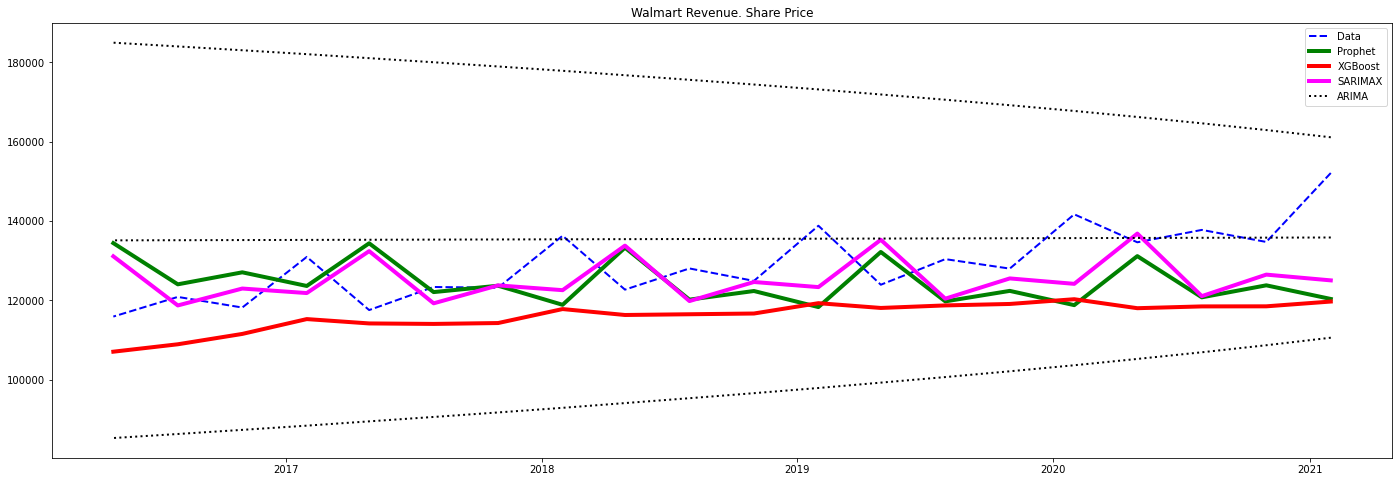

In [12]:
# Compare the forecasts
plt.figure(figsize=(24,8))
plt.plot(test, color='blue', label='Data', linestyle = '--', linewidth = 2)
plt.plot(train, color='blue', linestyle = '--', linewidth = 2)
plt.plot(test.index, forecast_P, label='Prophet', color='green', linewidth = 4)
plt.plot(test.index, forecast_X, label='XGBoost', color='red', linewidth = 4)
plt.plot(test.index, forecast_AS*1.75, label='SARIMAX', color='magenta', linewidth = 4)
plt.plot(test.index, forecast_A[0]*1.75, label='ARIMA', color='black', linestyle = ':', linewidth = 2)
plt.plot(test.index, forecast_A[2]*1.75, color='black', linestyle = ':', linewidth = 2)
# plt.plot(test.index, lstm_predictions, color='cyan', linewidth = 4)
plt.title('Walmart Revenue. Share Price')
plt.legend()


# Compare the forecasts
plt.figure(figsize=(24,8))
plt.plot(test, color='blue', label='Data', linestyle = '--', linewidth = 2)
plt.plot(test.index, forecast_P, label='Prophet', color='green', linewidth = 4)
plt.plot(test.index, forecast_X, label='XGBoost', color='red', linewidth = 4)
plt.plot(test.index, forecast_AS*1.75, label='SARIMAX', color='magenta', linewidth = 4)
plt.plot(test.index, forecast_A[0]*1.75, label='ARIMA', color='black', linestyle = ':', linewidth = 2)
plt.plot(test.index, forecast_A[2]*1.75, color='black', linestyle = ':', linewidth = 2)
# plt.plot(test.index, lstm_predictions, color='cyan', linewidth = 4)
plt.title('Walmart Revenue. Share Price')
plt.legend()

In [13]:
mean_absolute_error(test, forecast_A[0]), mean_absolute_error(test, forecast_P), mean_absolute_error(test, forecast_X)

(51776.01198063437, 11296.224957449147, 13057.980859375)

## <center> We can see, that model works, but requires tuning.


   


### Next steps:

- Building LSTM model
- Tuning models


### Findings and flaws:

- **ARIMA** showed a trend, but does not show real seasonal fluctuations, but **SARIMAX** predicted the exact behavior of the data
- **Prophet** showed a similar result with **SARIMAX** - very close to real data with seasonal changes.
- **XGBoost** will not be able to predict the curve, but it reacts fairly accurately to fluctuations without tuning. **Prophet** and **SARIMAX** models required tuning, but **XGBoost** works from the box. This is sometimes useful. But it works very slowly.
- We can use models to build time series for prediction, but in each case, a long and precise manual adjustment is required for a specific type of data.
- Each model has its own characteristics, advantages and disadvantages, there is no universal model that will answer all the questions. Therefore, we must select several models at once for specific data.
- The models are not perfect. Lots of flaws. More tuning is required.
